#### 0. Transformer 개요

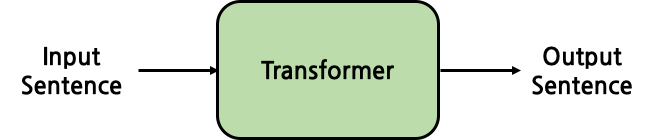

Trasformer는 크게 Encoder와 Decoder로 나뉜다.
- Encoder는 sentence를 input으로 받아 하나의 context를 생성해는 함수이다
- Decoder는 Encoder와 방향이 반대이다. context를 input으로 받아 sentence를 output으로 생성해낸다
- Encoder는 context를 생성해내고, Decoder는 context를 사용한다.

In [ ]:
class Transformer(nn.Module):

    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder


    def encode(self, x):
        out = self.encoder(x)
        return out


    def decode(self, z, c):
        out = self.decode(z, c)
        return out


    def forward(self, x, z):
        c = self.encode(x)
        y = self.decode(z, c)
        return y

#### 1. Encoder 개요
- Encoder는 6개의 Block으로 이루어져 있다.
- 첫번째 Encoder Block의 input은 전체 Encoder의 input으로 들어오는 문장 embdding이 된다
- 첫번째 block Output은 두번째 block input으로 사용된다.

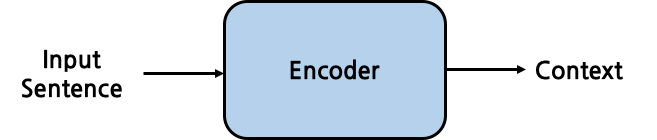

(상세)

- Encoder Block의 input과 output의 shape는 필연적으로 반드시 동일해야만 한다.
- 즉, Encoder Block은 shape에 대해 멱등(Idempotent) 하다.
- 6개의 Block이 서로의 출력을 입력으로 받기 때문에, 당연히 Encoder Block 뿐만 아니라 Encoder 전체도 shape에 대해 멱등(Idempotent)하다.

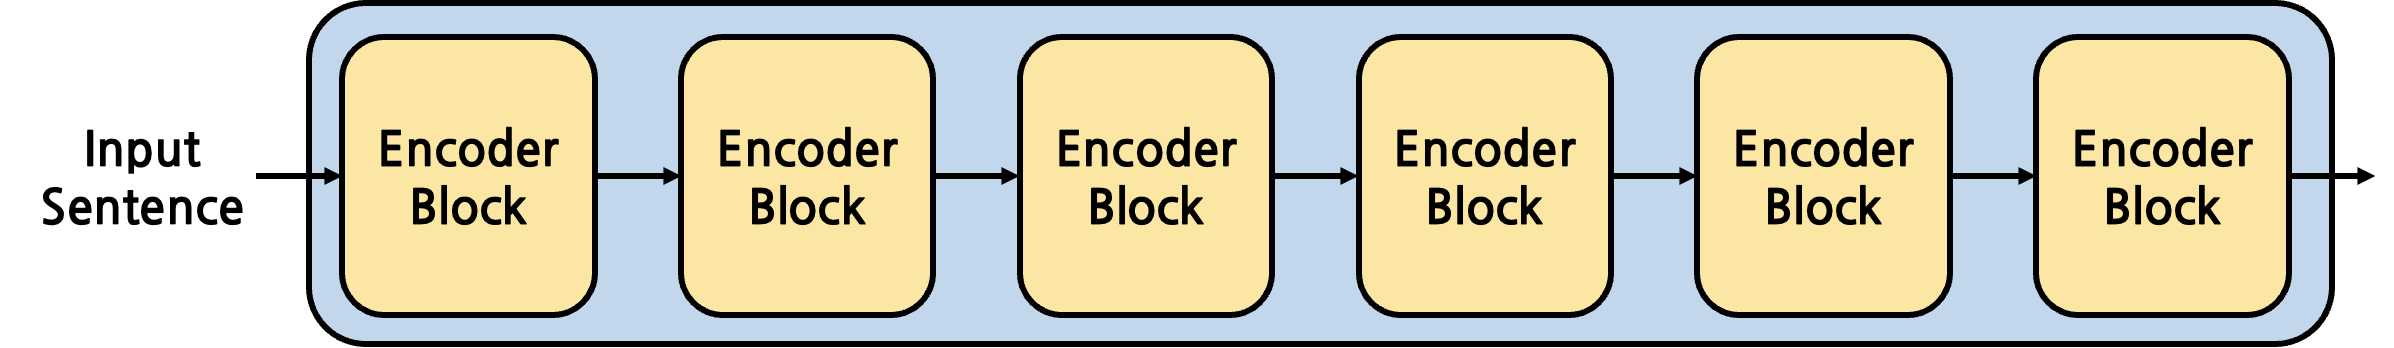

In [ ]:
class Encoder(nn.Module):

    def __init__(self, encoder_block, n_layer):  # n_layer: Encoder Block의 개수
        super(Encoder, self).__init__()
        self.layers = []
        for i in range(n_layer):
            self.layers.append(copy.deepcopy(encoder_block))


    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

#### 1.1. Encoder Block 상세
- ncoder Block은 크게 Multi-Head Attention Layer, Position-wise Feed-Forward Layer로 구성된다.
- Multi-Head Attention은 Scaled Dot-Product-Attention을 병렬적으로 여러개 수행하는 layer이다.
- Attention이라는 것은 넓은 범위의 전체 data에서 특정한 부분에 집중한다는 의미이다.
- Scaled Dot-Product Attention 자체를 줄여서 Attention으로 부르기도 한다.

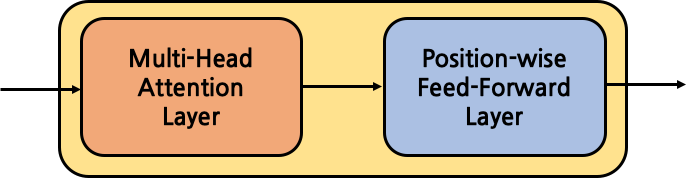

※ Self-Attention: 같은 문장 내의 두 token 사이의 Attention을 계산하는 것  
※ Cross-Attention: 서로 다른 두 문장에 각각 존재하는 두 token 사이의 Attention을 계산하는 것

**RNN vs Self-Attention**   
- RNN은 i 시점의 hidden state hi를 구하기 위해 $h_{i-1}$이 필요했다. 결국, 앞에서 부터 순차 계산을 해나가서 $h_i$, $h_{i+1}$을 구하기 때문에 병렬처리가 불가능 했다.
- 하지만 Self-Attention은 모든 token 쌍 사이의 attention을 한 번의 행렬 곱으로 구해내기 때문에 손쉽게 병렬 처리가 가능하다.
- Recurrent Network는 시간이 진행될수록 오래된 시점의 token에 대한 정보가 점차 희미해져간다. 왜냐하면, {hm, h_{m+1}, ... h_n} 으로 특정 구간 token들의 연관성을 살피기 때문이다.
- Self-Attention은 문장에 token이 n개 있다고 가정할 경우, n×n 번 연산을 수행해 모든 token들 사이의 관계를 직접 구해낸다. 중간의 다른 token들을 거치지 않고 바로 direct한 관계를 구하는 것이기 때문에 Recurrent Network에 비해 더 명확하게 관계를 잡아낼 수 있다.    


**Query, Key, Value**  
- 아래 문장을 예에서 it이 어느 것을 지칭하는지 알아내는 상황이라고 가정하자.  
"The animal didn’t cross the street, because it was too tired."
  
- 이 경우에는 Query는 ‘it’으로 고정이다. **Key, Value는 서로 완전히 같은 token을 가리키는데**, 문장의 시작부터 끝까지 모든 token들 중 하나가 된다.

- Key와 Value는 문장의 처음부터 끝까지 탐색한다고 이해하면 된다. Query는 고정되어 하나의 token을 가리키고, Query와 가장 부합하는(Attention이 가장 높은) token을 찾기 위해서 Key, Value를 문장의 처음부터 끝까지 탐색한다.
  
- Query, Key, Value는 input으로 들어오는 동일한 token embedding vector를 FC에 넣어 벡터를 생성하여 구하며 shape는 서로 같다. **하지만, Query, Key, Value를 생성하는 FC는 서로 다르다. 값도 서로 다르다** 
- 정리하면, 각각 별개의 FC layer로 구해진 Query, Key, Value가 구체적인 값은 다를지언정 같은 shape($d_k$)를 갖는 vector가 된다는 것을 알 수 있다.
  
- 여기서, Key와 Value가 완전히 같은 token을 가리킨다면 왜 두 개가 따로 존재하는지 의문이 들 수 있다. 결론부터 말하자면 Key와 Value의 실제 값은 다르지만 의미적으로는 여전히 같은 token을 의미한다. Key와 Value는 이후 Attention 계산 과정에서 별개로 사용하게 된다


**Scaled Dot-Product Attention**
- Query(Q), Key(K), Value(V)를 활용해 Query's Attention을 계산해 본다.
- Q는 현재 시점의 token을, K와 V 는 Attention을 구하고자 하는 대상 token을 의미한다.
- 미리 말하자면, 구해진 Query's Attention도 Q, K, V와 같은 shape($d_k$)를 가지는 벡터이다. 

$$ \text{Query's Attention}\left( Q, K, V \right) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right) V $$

- 위의 예시에서 'it'을 Q로 두고, K, V를 'animal'로 두고 Attention을 구한다고 가정해 보자
- $d_k$(Q, K, V가 FC를 통과해 구해진 벡터의 Shape)가 3이라고 하면 아래와 같은 모양이 된다.
- Q와 K는 같은 Shape이며 이 둘을 곱하기 위해 K를 Transpose 한 후에 $QK^T$를 구한다. 이때 값이 너무 커지지 않도록 $\sqrt{d_k}$로 나눠준다. 즉 Scaling 해준다.
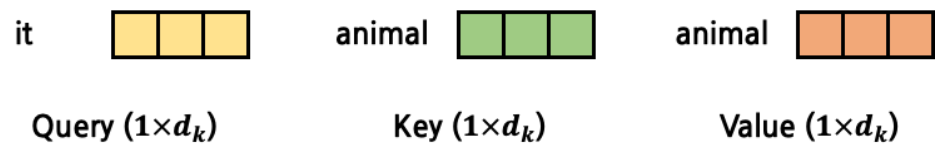
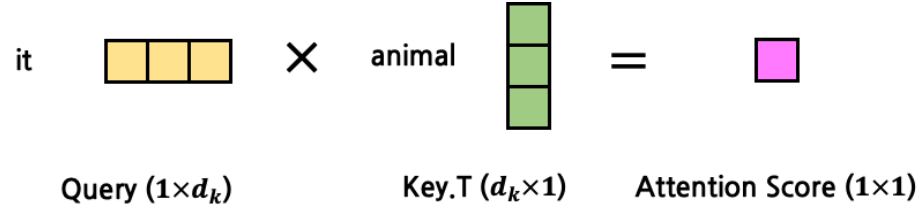

==> 즉, 둘 사이의 연관성을 점수로 나타내려면 무식하게 곱해서 점수로 나타낸다.

- it과 문장 토큰을 이렇게 1:1로 구하는 것 보다 1:N으로 구하는 것이 효율적일 것이다.
- Q vector 1개에 대해서 Attention을 계산한다고 했을 때, K와 V는 각각 문장 토큰 갯수 길이 만큼의 n길이의 vector가 된다.
- 이때, Q, K, V 벡터 차원은 모두 $d_k$로 동일하다.
- 정리하면, 아래와 같이 시각화 할 수 있다.
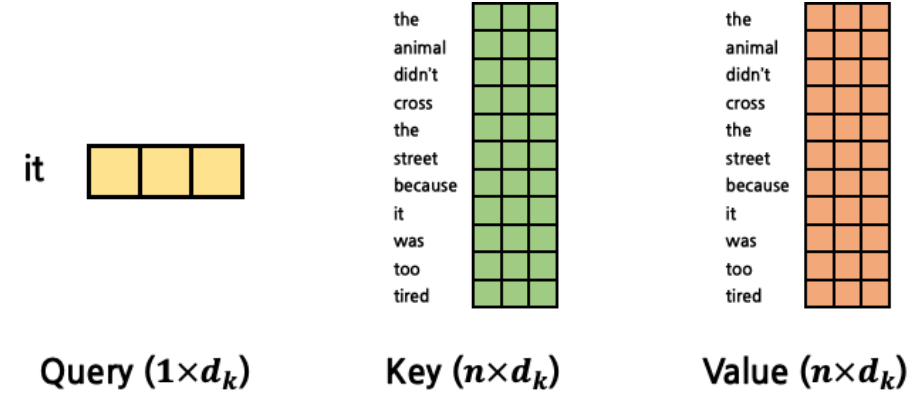
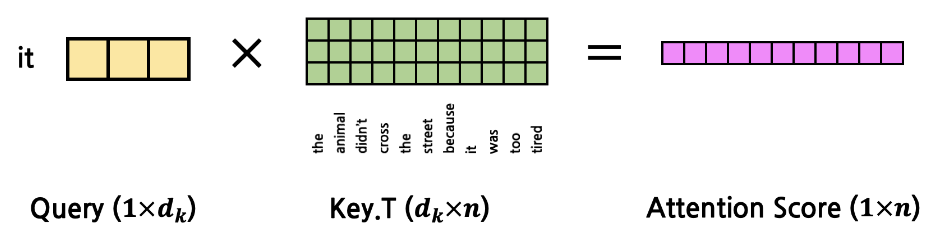

- 그 결과 Attention Score는 1×n의 matrix가 되는데, 이는 Q의 token과 문장 내 모든 token들 사이의 Attention Score를 각각 계산한 뒤 concatenate한 것과 동일하다. 이를 행렬곱 1회로 수행한 것이다.
- 이렇게 구한 Attention Score는 softmax를 사용해 확률값으로 변환하게 된다. 그 결과 각 Attention Probability는 모두 더하면 1인 확률값이 된다. 확률 값은 Q token과 각각의 token이 얼마나 연관성을 갖는지에 대한 비율이 된다.
- 위에서 구한 Attention Probability를 최종적으로 V와 곱하게 되는데, 이는 Q 대비 각 토큰의 확률 만큼만 반영하겠다는 의미이다.
<span style="color:greenyellow">   
==> Key와 Value는 동일한 token 이지만 Key는 Query와의 연관성 즉, 확률 구하는데 사용되며 Value는 구해진 확률 값이 곱해지는 주체이다.
</span>

- Query's Attention을 아래와 같이 정리할 수 있다.
- 앞에서 언급했듯, Query's Attention도 Q, K, V와 같은 shape($d_k$)를 가지는 벡터 1개 이다.
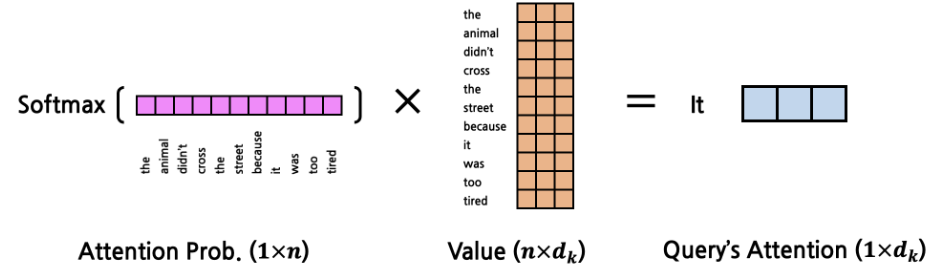

- 지금까지의 Attention 연산은 ‘it’이라는 한 token에 대한 Attention을 구한 것이다. 그러나 우리는 문장 내에서 ‘it’에 대한 Attention만 구하고자 하는 것이 아니다. 모든 token에 대한 Attention을 구해내야만 한다. (왜?)
  
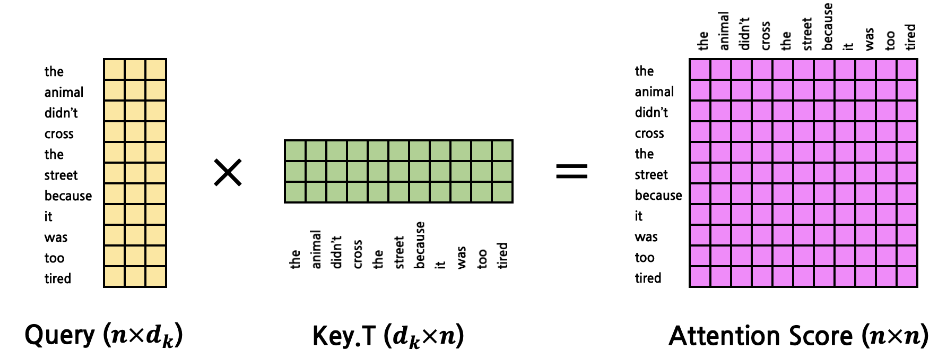
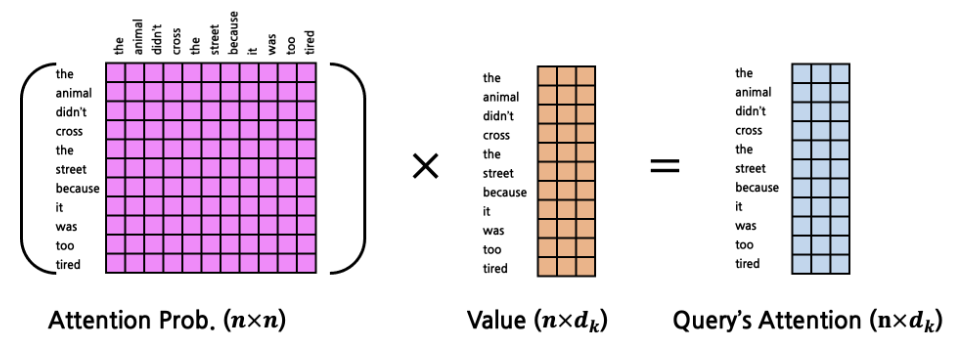


- 최종적으로 문장 전체를 Query 벡터로 나타낼 때, Self-Attention을 거쳐 계산한 Query's Attention은 아래와 같다.
- Self-Attention 연산 역시 shape에 멱등(Idempotent)하다
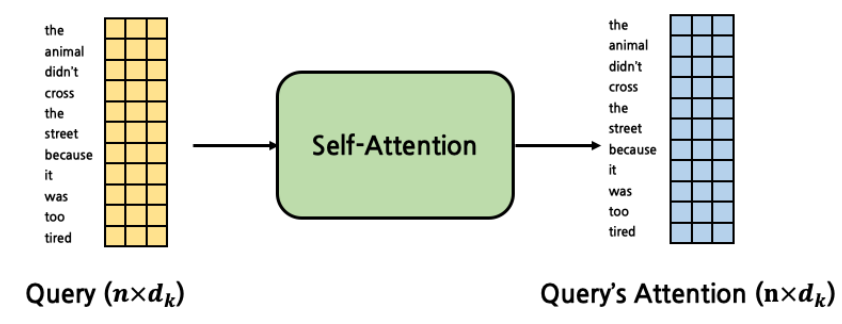

<span style="color:greenyellow">
==> 쉽게 표현하면, token이 서로가 서로에 대한 연관성을 확률 값으로 표현한다
</span>

- 위에서 본 Q, K, V 토큰 임베딩 벡터(각각 $nxd_k$ 차원)을 구하는 FC는 각기 다르다고 하였다.
- FC layer의 input은 word embedding vector들이고, output은 각각 Q, K, V이다. 
- 입력 shape는 모두 $n \times d_{embed}$이며, 출력 shape는 모두 $n x d_k$ 이다.
- 각각의 FC layer는 서로 다른 weight matrix ($d_{embed} \times d_k$)를 갖고 있기 때문에 output의 shape는 모두 동일할지라도, Q, K, V 의 실제 값들은 모두 다르다.
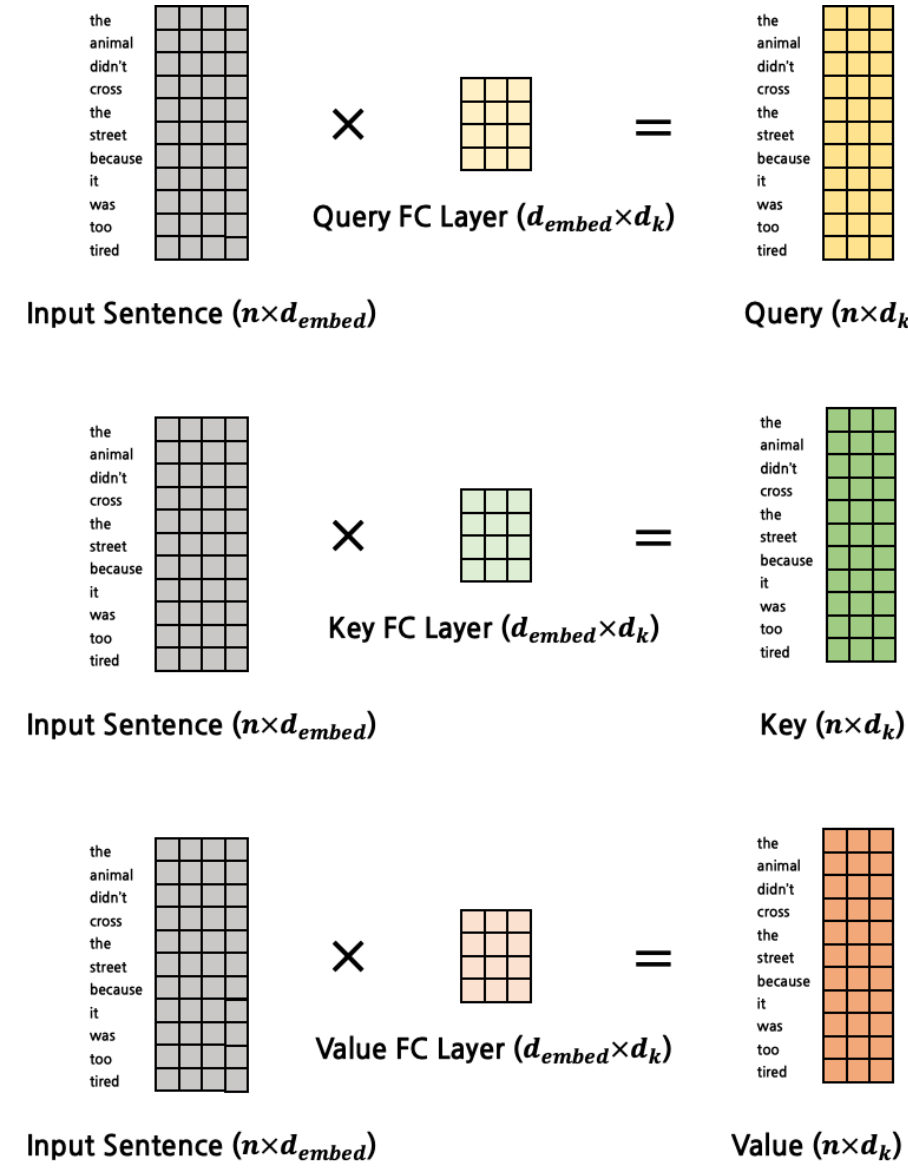

**Pad Masking**  
- "The animal didn’t cross the street, because it was too tired."  
- 문장을 word 단위로 tokenize(단순히 python의 split()을 사용)한다면 token의 개수는 총 11개이다.
- 실제 model 학습 과정에서는 한 문장 씩이 아닌 mini-batch씩 여러 문장이 와야 하는데 각 문장 마다의 length가 다를 경우 batch를 만들어낼 수 없다. 
- 이러한 문제를 해결하기 위해 seq_len(해당 mini-batch 내 token 개수의 최대 값)을 지정하게 되는데, 만약 seq_len
이 20이라고 한다면 위 문장에서는 9개의 빈 token이 있게 된다.
- 그런데, 이렇게 생겨난 비어있는 pad token에는 attention이 부여되어서는 안된다(Token이 없는 곳은 연관성을 파악할 필요가 없다)
- 따라서, 이러한 pad token들에 대해 attention이 부여되지 않도록 처리하는 것이 pad masking이다.
- masking은 (seq_len × seq_len) shape의 mask matrix를 곱하는 방식으로 이뤄지는데 mask matrix에서 pad token에 해당하는 row, column의 모든 값은 0이고, 그외는 모두 1이다.
- 이러한 연산은 scaling과 softmax 사이에 수행하게 되는데, 사실은 scaling 이전, 이후 언제 적용하든 차이는 없다.
- scaling은 단순히 모든 값을 dk로 일괄 나누는 작업이기 때문이다. 대신 반드시 Q와 K 의 행렬곱 이후, softmax 이전에 적용되어야 한다. 그래야만, softmax 계산 이후 확률 합이 1이 되기 때문이다.
- 아래와 같이 이해하면 편할 듯 하다
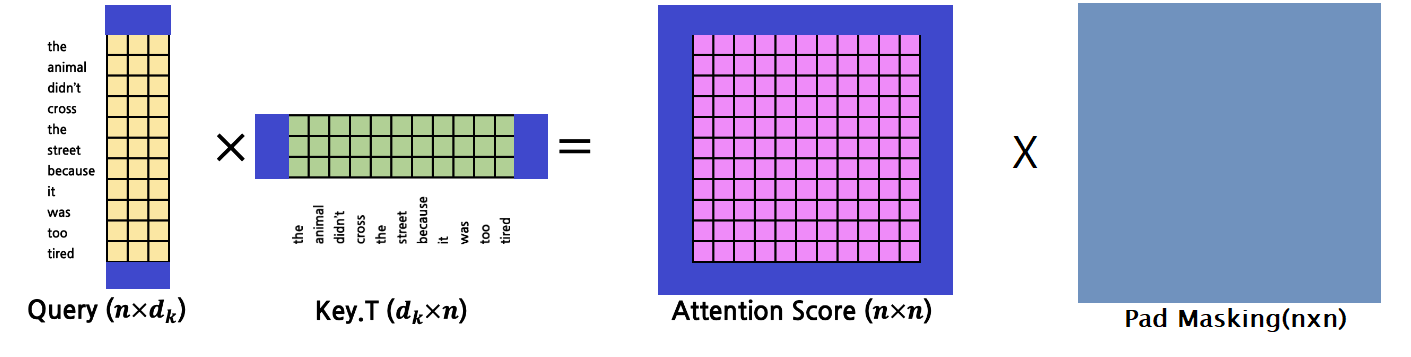

**Self-Attention Code in Pytorch**